In [1]:
from datasets import load_dataset, concatenate_datasets, DatasetDict, load_from_disk

load_from_file = False

if load_from_disk:
    datasets = load_from_disk("../swag.hf")
else:
    datasets = load_dataset("swag", "regular")
    # the labels for the test split are not public, therefore we create our own split
    # 60% train, 20% validation, 20% test
    merged_datasets = concatenate_datasets([datasets["train"], datasets["validation"]])
    
    train_testvalid = merged_datasets.train_test_split(test_size=0.4)
    # Split the 10% test + valid in half test, half valid
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
    # gather everyone if you want to have a single DatasetDict
    datasets = DatasetDict({
        'train': train_testvalid['train'],
        'test': test_valid['test'],
        'validation': test_valid['train']})

    datasets.save_to_disk("../swag.hf")

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

In [3]:
import torch.nn as nn
from transformers import ModernBertModel

class ModernBERTForMultipleChoice(nn.Module):
    def __init__(self, model_name="answerdotai/ModernBERT-base"):
        super(ModernBERTForMultipleChoice, self).__init__()
        self.modernBERT = ModernBertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1)
        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        bsz, num_choices, seq_len = input_ids.size()
        
        input_ids = input_ids.view(-1, seq_len)
        attention_mask = attention_mask.view(-1, seq_len)
        # Pass through BERT
        outputs = self.modernBERT(input_ids=input_ids, attention_mask=attention_mask)
        # Extract [CLS] token representation: (batch_size * 4, hidden_size)
        hidden_state = outputs.last_hidden_state  # (batch_size*num_choices, seq_len, hidden_size)
        pooled_output = hidden_state[:, 0, :]  # Last token representation

        logits = self.classifier(self.dropout(pooled_output))  # (batch_size*num_choices, 1)
        reshaped_logits = logits.view(bsz, num_choices)  # (batch_size, num_choices)
        
        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = self.loss_fct(reshaped_logits, labels)

        return {"loss": loss, "logits": reshaped_logits}

In [4]:
# adopted from: https://huggingface.co/docs/transformers/tasks/multiple_choice
def preprocess_function(examples):
    first_sentences = [[context] * 4 for context in examples["sent1"]]
    question_headers = examples["sent2"]
    answer_choices = [examples[f"ending{i}"] for i in range(4)]

    second_sentences = [
        [f"{header} {choice}" for choice in choices]
        for header, choices in zip(question_headers, zip(*answer_choices))
    ]

    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    tokenized = tokenizer(
        first_sentences,
        second_sentences,
        truncation=True,
        padding="max_length", 
        max_length=128,        
        return_tensors="pt",
    )

    return {
        "input_ids": tokenized["input_ids"].view(-1, 4, tokenized["input_ids"].shape[-1]),
        "attention_mask": tokenized["attention_mask"].view(-1, 4, tokenized["attention_mask"].shape[-1]),
        "labels": examples["label"],
    }

encoded_dataset = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/18710 [00:00<?, ? examples/s]

In [5]:
import numpy as np

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

In [6]:
from transformers import Trainer, TrainingArguments

model = ModernBERTForMultipleChoice("answerdotai/ModernBERT-base")

training_args = TrainingArguments(
    "modernBert-finetuned-swag",
    evaluation_strategy = "steps",
    eval_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

/home/e12117772/2024W-DLNLP-BERT/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/e12117772/2024W-DLNLP-BERT/.venv/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
1000,0.763400,0.709698,0.725494
2000,0.671500,0.664722,0.746980
3000,0.640900,0.620603,0.759220
4000,0.368100,0.670170,0.767237
5000,0.350900,0.666765,0.766435
6000,0.340900,0.697606,0.773437
7000,0.341700,0.662661,0.778568
8000,0.103700,1.274919,0.769909
9000,0.120500,1.254937,0.771726
10000,0.112800,1.304342,0.774506


TrainOutput(global_step=10527, training_loss=0.3895802169010557, metrics={'train_runtime': 6404.1956, 'train_samples_per_second': 26.294, 'train_steps_per_second': 1.644, 'total_flos': 0.0, 'train_loss': 0.3895802169010557, 'epoch': 3.0})

In [7]:
evaluated = trainer.evaluate()
evaluated

{'eval_loss': 1.301719069480896,
 'eval_accuracy': 0.7757349014282227,
 'eval_runtime': 178.4577,
 'eval_samples_per_second': 104.843,
 'eval_steps_per_second': 6.556,
 'epoch': 3.0}

In [8]:
import pandas as pd
training_history_modernBert = pd.DataFrame(trainer.state.log_history)
training_history_modernBert.epoch = training_history_modernBert.epoch.astype(int)
training_history_modernBert.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
0,0.9297,34.514885,0.000019,500,0.709698,0.725494,181.0070,103.366,6.464,NaN,NaN,NaN,NaN,NaN
1,0.3681,11.521522,0.000012,4000,0.670170,0.767237,178.3666,104.896,6.560,NaN,NaN,NaN,NaN,NaN
2,0.1229,35.901955,0.000006,7500,1.274919,0.769909,178.4724,104.834,6.556,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,10527,1.301719,0.775735,178.4577,104.843,6.556,6404.1956,26.294,1.644,0.0,0.38958


In [9]:
test_pred = trainer.predict(encoded_dataset["test"])
test_pred.metrics

{'test_loss': 1.2597143650054932,
 'test_accuracy': 0.7780449986457825,
 'test_runtime': 178.6239,
 'test_samples_per_second': 104.751,
 'test_steps_per_second': 6.55}

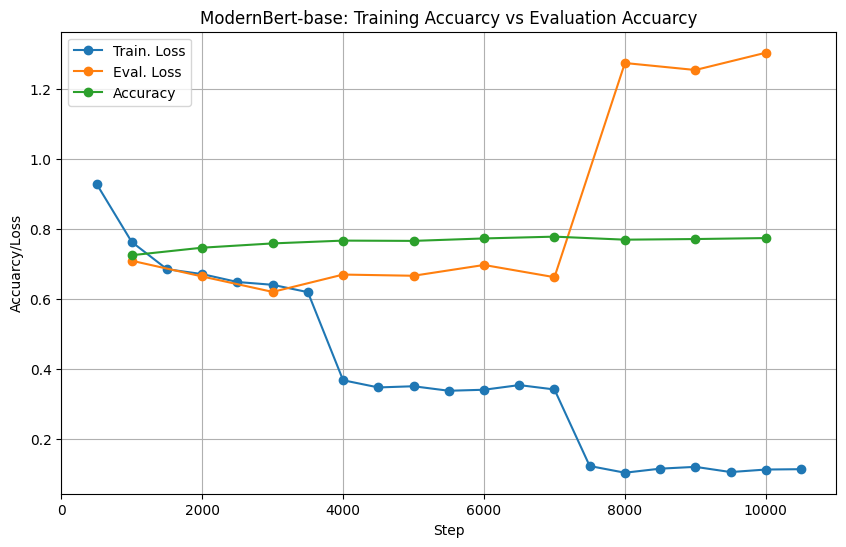

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
data = training_history_modernBert[["loss", "eval_loss", "step", "eval_accuracy"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Accuracy"]
data = data[:-1]  # drop last row
data = pd.melt(data, ['Training Steps']).dropna()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))

# Plot each variable separately without using groupby
train_loss = data[data['variable'] == "Train. Loss"]
eval_loss = data[data['variable'] == "Eval. Loss"]
acc = data[data['variable'] == "Accuracy"]

plt.plot(train_loss["Training Steps"], train_loss["value"], marker='o', label="Train. Loss")
plt.plot(eval_loss["Training Steps"], eval_loss["value"], marker='o', label="Eval. Loss")
plt.plot(acc["Training Steps"], acc["value"], marker='o', label="Accuracy")

# Labels and Title
plt.ylabel('Accuarcy/Loss')
plt.xlabel('Step')
plt.title('ModernBert-base: Training Accuarcy vs Evaluation Accuarcy')
plt.legend()
plt.grid(True)

# Show plot
plt.savefig('ModernBert_swag_finetuned.png')

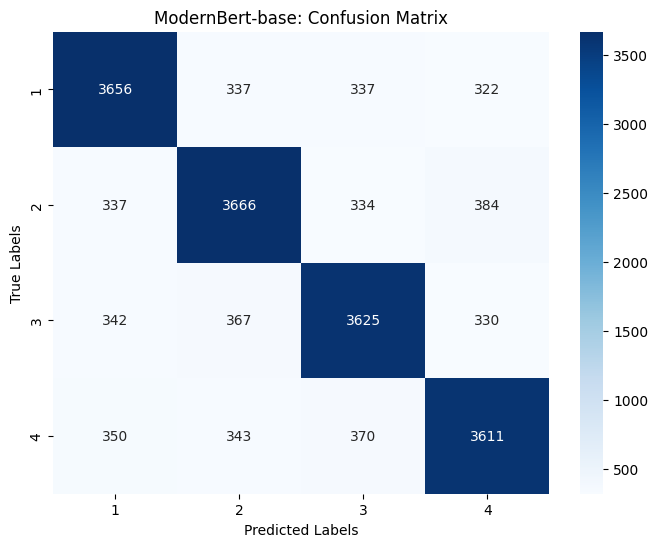

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

import evaluate

metric = evaluate.load("confusion_matrix")

predictions = np.argmax(test_pred.predictions, axis=-1)
metric.add_batch(predictions=predictions, references=datasets["test"]["label"])

# Compute confusion matrix
conf_matrix = metric.compute()['confusion_matrix']

# Define class labels manually (adjust as needed)
labels = ["1", "2", "3", "4"]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ModernBert-base: Confusion Matrix')
plt.savefig('swag_ModernBert_confusion_matrix.png')